In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor


In [5]:
call = pd.read_csv('H2HBABBA3069.csv')
df = pd.DataFrame(call)
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [6]:
df_drop = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_drop.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                  3
isOpen                      0
dtype: int64

In [7]:
df_drop1 = df_drop.drop(['area_business'], axis = 1)

# There are 4175 rows with clear date missing which is useful in finding payment delay predictions, so these rows are useless.
df_drop2 = df_drop1.dropna(axis = 0, how ='any') # additionally removing those null values too for invoice_id
df_drop2.shape

(39997, 17)

In [8]:
def change_date(x_type):
    x = str(x_type)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [9]:
df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date']) 

# Creating target variable
df_drop2['target'] = (df_drop2['clear_date'] - df_drop2['due_date']).dt.days
# df_drop2.head(5) target value +ve means there was a delay in payment.

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [10]:
df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)

print(pd.to_datetime(df_drop2['document_create_date']).min()) 
print(pd.to_datetime(df_drop2['document_create_date']).max())

2018-12-27 00:00:00
2020-02-27 00:00:00


C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
x_train = df_drop2[df_drop2['document_create_date'] <= '2020-01-01'].copy()
x_test = df_drop2[df_drop2['document_create_date'] > '2020-01-01'].copy()

In [12]:

x_train.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,34977.000000,3.497700e+04,3.497700e+04,34977.0,34977.000000,3.497700e+04,34977.0,34977.000000
mean,2019.008720,2.012170e+09,2.019082e+07,1.0,32151.640152,2.012170e+09,0.0,-5.586328
std,0.092974,2.782505e+08,1.123117e+03,0.0,39865.508409,2.782505e+08,0.0,89.118500
min,2019.000000,1.928502e+09,2.018123e+07,1.0,0.630000,1.928502e+09,0.0,-333.000000
25%,2019.000000,1.929092e+09,2.019042e+07,1.0,4797.000000,1.929092e+09,0.0,-5.000000
50%,2019.000000,1.929612e+09,2.019071e+07,1.0,17277.790000,1.929612e+09,0.0,0.000000
75%,2019.000000,1.930028e+09,2.019101e+07,1.0,46554.280000,1.930028e+09,0.0,4.000000
max,2020.000000,2.960605e+09,2.020030e+07,1.0,860880.000000,2.960605e+09,0.0,318.000000


In [13]:

x_test.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,5020.0,5.020000e+03,5.020000e+03,5020.0,5020.000000,5.020000e+03,5020.0,5020.000000
mean,2020.0,2.008882e+09,2.020022e+07,1.0,31511.953223,2.008882e+09,0.0,49.199203
std,0.0,2.717071e+08,1.943337e+02,0.0,37358.136612,2.717071e+08,0.0,89.136652
min,2020.0,1.930334e+09,2.019113e+07,1.0,10.950000,1.930334e+09,0.0,-116.000000
25%,2020.0,1.930410e+09,2.020020e+07,1.0,4601.797500,1.930410e+09,0.0,-1.000000
50%,2020.0,1.930469e+09,2.020022e+07,1.0,16799.745000,1.930469e+09,0.0,2.000000
75%,2020.0,1.930536e+09,2.020030e+07,1.0,46697.057500,1.930536e+09,0.0,60.000000
max,2020.0,2.960617e+09,2.020061e+07,1.0,321350.000000,2.960617e+09,0.0,310.000000


In [14]:
X_train = x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
X_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

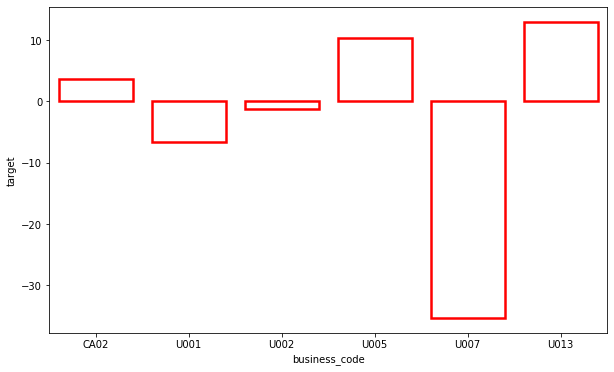

In [15]:
temp = pd.DataFrame(X_train.groupby(['business_code'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="business_code", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

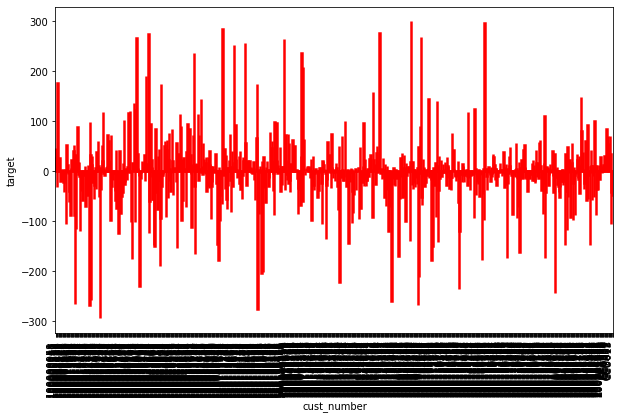

In [16]:
temp = pd.DataFrame(X_train.groupby(['cust_number'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
graph = sns.barplot(x="cust_number", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

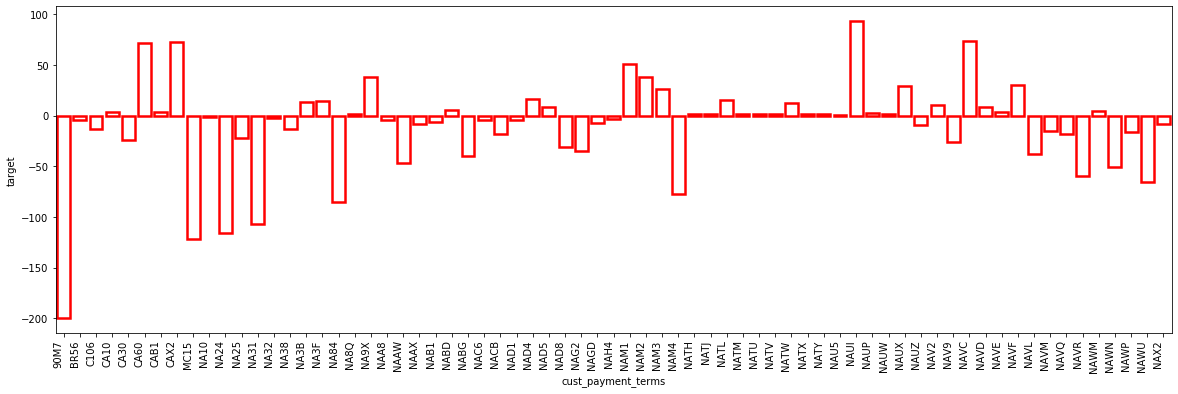

In [17]:
temp = pd.DataFrame(X_train.groupby(['cust_payment_terms'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(20,6))
graph = sns.barplot(x="cust_payment_terms", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

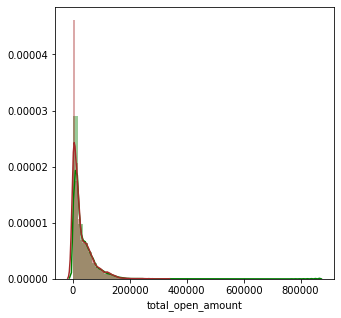

In [18]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_train['total_open_amount'],color='green')
sns.distplot(X_test['total_open_amount'],color='brown')

In [19]:
def Transform(x):
    return np.log(x)

X_train['total_open_amount'] = X_train['total_open_amount'].apply(Transform)
X_test['total_open_amount'] = X_test['total_open_amount'].apply(Transform)

In [21]:
X_train['cust_number'].nunique()


981

In [22]:
X_test['cust_number'].nunique()

486

In [23]:
X_train = X_train.drop([ 'due_in_date', 'isOpen'], axis = 1)
X_test = X_test.drop([ 'due_in_date', 'isOpen'], axis = 1)

In [24]:
X_train.head(1)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target
2,U001,200759878,SA in,2019-12-27,2019,1930251991,09-12-2019,2019-12-09,USD,10.48182,2019-12-09,NAH4,1.930252e+09,2019-12-24,3


In [25]:
ref = dict(X_train['cust_number'].value_counts())


X_train['cust_number_new'] = X_train['cust_number'].map(ref)

In [26]:
ref1 = dict(X_test['cust_number'].value_counts())


X_test['cust_number_new'] = X_test['cust_number'].map(ref1)

In [27]:
X_train = X_train.replace(['U002', 'U005', 'U007'], 'other')
X_test = X_test.replace(['U002', 'U005', 'U007'], 'other')

business = pd.get_dummies(X_train['business_code'])
business1 = pd.get_dummies(X_test['business_code'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
X_train = pd.concat([X_train, business], axis=1)
X_test = pd.concat([X_test, business1], axis=1)

X_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,cust_number_new,CA02,U001,U013,other
2,U001,200759878,SA in,2019-12-27,2019,1930251991,09-12-2019,2019-12-09,USD,10.481820,2019-12-09,NAH4,1.930252e+09,2019-12-24,3,972,0,1,0,0
3,U001,200797984,PIGGLY foundation,2019-01-28,2019,1928606578,11-01-2019,2019-01-10,USD,11.094572,2019-01-11,NAA8,1.928607e+09,2019-01-26,2,15,0,1,0,0
4,U001,200769623,WAL-MAR trust,2019-07-30,2019,1929628633,19-07-2019,2019-07-17,USD,9.647698,2019-07-19,NAH4,1.929629e+09,2019-08-03,-4,8201,0,1,0,0
5,U001,200769623,WAL-MAR trust,2019-10-07,2019,1929560422,30-06-2019,2019-06-29,USD,6.956869,2019-06-30,NAH4,1.929560e+09,2019-07-15,84,8201,0,1,0,0
8,U001,200763814,SYSCO F trust,2019-04-11,2019,1929941294,30-09-2019,2019-09-30,USD,10.661512,2019-09-30,NA32,1.929941e+09,2019-11-01,-204,120,0,1,0,0


In [28]:
ref2 = dict(X_train['cust_payment_terms'].value_counts())


X_train['cust_payment_terms_new'] = X_train['cust_payment_terms'].map(ref2)

In [29]:
ref3 = dict(X_test['cust_payment_terms'].value_counts())


X_test['cust_payment_terms_new'] = X_test['cust_payment_terms'].map(ref3)



In [30]:

X_train.head(2)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,...,cust_payment_terms,invoice_id,due_date,target,cust_number_new,CA02,U001,U013,other,cust_payment_terms_new
2,U001,200759878,SA in,2019-12-27,2019,1930251991,09-12-2019,2019-12-09,USD,10.481820,...,NAH4,1.930252e+09,2019-12-24,3,972,0,1,0,0,9068
3,U001,200797984,PIGGLY foundation,2019-01-28,2019,1928606578,11-01-2019,2019-01-10,USD,11.094572,...,NAA8,1.928607e+09,2019-01-26,2,15,0,1,0,0,14169


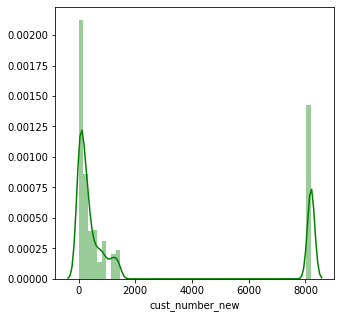

In [31]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_train['cust_number_new'],color='green')

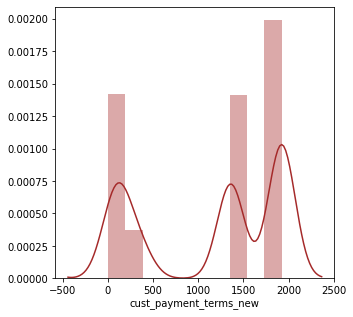

In [32]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_test['cust_payment_terms_new'],color='brown')

In [33]:
X_train['cust_number_new'].skew()

1.2175907294870238

In [34]:
X_train['cust_payment_terms_new'].skew()

-0.35956011208792543

In [35]:
from scipy.stats import boxcox

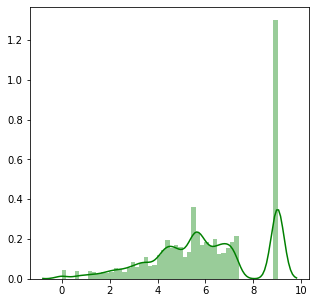

In [36]:
df = boxcox(X_train['cust_number_new'], 0.0)
# df1 = boxcox(df, 0.0)
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(df,color='green')

In [37]:
X_train['cust_number_new'] = df

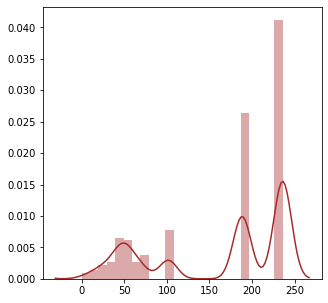

In [38]:
df1 = boxcox(X_train['cust_payment_terms_new'], 0.5)
# df1 = boxcox(df, 0.0)
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(df1,color='brown')

In [39]:
X_train['cust_payment_terms_new'] = df1

In [40]:
df2 = boxcox(X_test['cust_number_new'], 0.0)
X_test['cust_number_new'] = df2

In [41]:
df3 = boxcox(X_test['cust_payment_terms_new'], 0.0)
X_test['cust_payment_terms_new'] = df3

In [42]:
import datetime as dt
X_train['year'] = X_train['document_create_date'].dt.year
X_train['month'] = X_train['document_create_date'].dt.month
X_train['day'] = X_train['document_create_date'].dt.day
X_train['week'] = X_train['document_create_date'].dt.week
X_train['which_day'] = X_train['document_create_date'].dt.dayofweek
X_train['quarter'] = X_train['document_create_date'].dt.quarter

In [43]:
X_train.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms', 'invoice_id', 'due_date', 'target',
       'cust_number_new', 'CA02', 'U001', 'U013', 'other',
       'cust_payment_terms_new', 'year', 'month', 'day', 'week', 'which_day',
       'quarter'],
      dtype='object')

In [44]:
invoice_dic = {'USD': 1, 'CAD': 0}
X_train['invoice_currency'] = X_train['invoice_currency'].map(invoice_dic)

In [45]:
X_test['year'] = X_test['document_create_date'].dt.year
X_test['month'] = X_test['document_create_date'].dt.month
X_test['day'] = X_test['document_create_date'].dt.day
X_test['week'] = X_test['document_create_date'].dt.week
X_test['which_day'] = X_test['document_create_date'].dt.dayofweek
X_test['quarter'] = X_test['document_create_date'].dt.quarter

X_test['invoice_currency'] = X_test['invoice_currency'].map(invoice_dic)

In [46]:
X_train1 = X_train.drop(['business_code', 'cust_number', 'name_customer', 'doc_id', 'cust_payment_terms'
                        , 'invoice_id'], axis = 1)

X_test1 = X_test.drop(['business_code', 'cust_number', 'name_customer', 'doc_id', 'cust_payment_terms'
                        , 'invoice_id'], axis = 1)

In [47]:
X_train1['clear_date']= pd.to_datetime(X_train1['clear_date']) 

# Creating target variable
X_train1['expected_target'] = (X_train1['due_date'] - X_train1['baseline_create_date']).dt.days

X_test1['clear_date']= pd.to_datetime(X_test1['clear_date']) 

# Creating target variable
X_test1['expected_target'] = (X_test1['due_date'] - X_test1['baseline_create_date']).dt.days

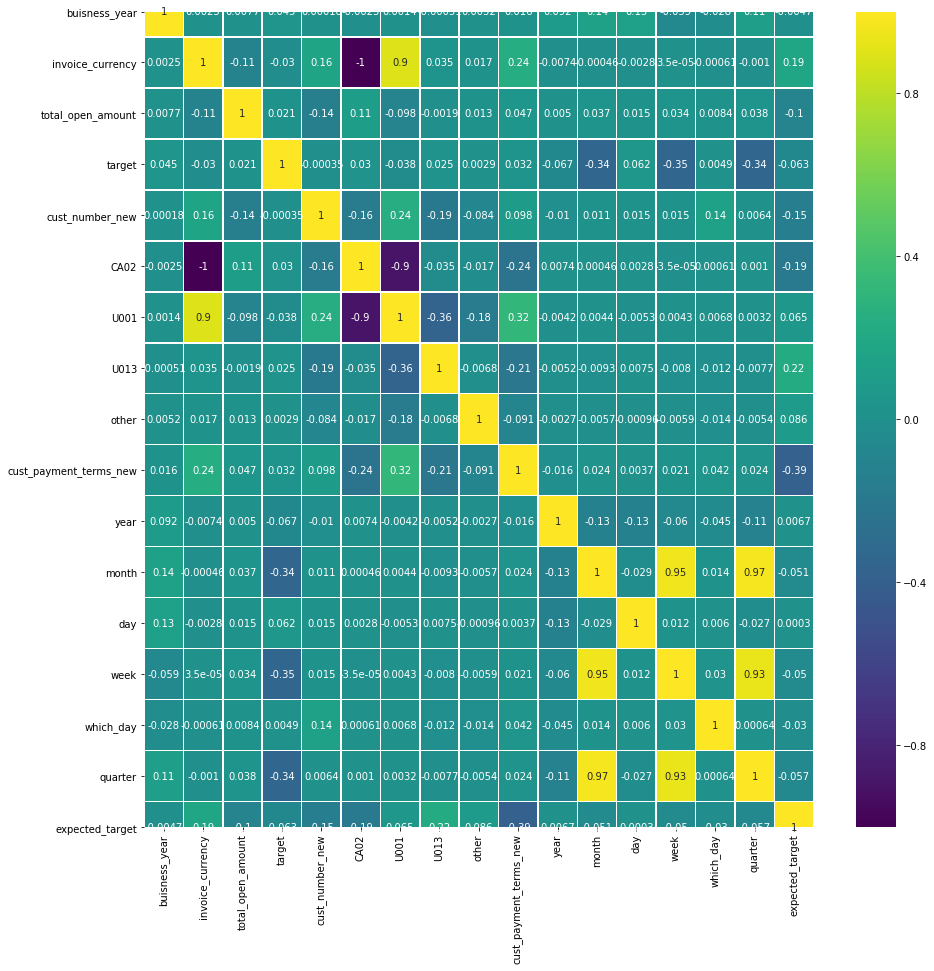

In [48]:
plt.figure(figsize=(15,15))
sns.heatmap(X_train1.corr(),annot=True,cmap='viridis',linewidths=.5)

In [49]:
X_final = X_train1.drop(['clear_date', 'posting_date', 'document_create_date', 'baseline_create_date','due_date'], axis = 1)

X_final_test = X_test1.drop(['clear_date', 'posting_date', 'document_create_date', 'baseline_create_date','due_date'], axis = 1)

In [50]:
X_final = X_final.drop(['CA02', 'week', 'U001'], axis = 1)

X_final_test = X_final_test.drop(['CA02', 'week', 'U001'], axis = 1)

In [51]:
X_final['target'] = X_train1['target']

In [52]:
y = X_final['target']
X_final = X_final.drop(['target'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.1, random_state=0)

In [53]:

l = list(np.isfinite(ytrain))
print([x for x in l if x == False])

[]


In [54]:
lp = list(np.isfinite(Xtrain))
print([x for x in lp if x == False])

[]


In [55]:
random_model = RandomForestRegressor(n_estimators=500, random_state = 42)

In [56]:
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

93.82 %


In [57]:
random_model_accuracy1 = round(random_model.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

51.25 %


In [58]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
xtrain = sc.fit_transform(Xtrain)
xtest = sc.transform(Xtest)

In [59]:

random_model.fit(xtrain, ytrain)
y_pred = random_model.predict(xtest)

In [60]:
random_model_accuracy2 = round(random_model.score(xtrain, ytrain)*100,2)
print(round(random_model_accuracy2, 2), '%')

93.83 %


In [61]:
random_model_accuracy3 = round(random_model.score(xtest, ytest)*100,2)
print(round(random_model_accuracy3, 2), '%')

51.21 %


In [62]:
print(random_model.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [63]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 255, 311, 366, 422, 477, 533, 588, 644, 700], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 23, 28, 32, 37, 41, 46, 50, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [64]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

# n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [65]:
rf_random.best_params_

{'n_estimators': 644,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 19,
 'bootstrap': False}

In [66]:
random_model1 = RandomForestRegressor(n_estimators = 588, min_samples_split = 10, min_samples_leaf = 1, max_features = 'sqrt',
                                      max_depth = None, bootstrap = True)

In [67]:
random_model1.fit(Xtrain, ytrain)

y_pred3 = random_model1.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model1.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

76.31 %


In [68]:
random_model_accuracy1 = round(random_model1.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

53.81 %
